In [73]:
### Si données locales
library(Matrix)
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)

m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA

# Cosinus normal des lignes d'une matrice
matrix.cos <- function(m) {
     (m %*% t(m)) / ( t(matrix(sqrt(rowSums(m^2)),nrow(m),nrow(m)))
                    * (sqrt(rowSums(m^2))) )
}
# on normalise les ages
u.user.norm <- u.user
u.user.norm$age = (u.user.norm$age - min(u.user.norm$age)) / (max(u.user.norm$age) - min(u.user.norm$age))

# on normalise les votes
u.data.norm <- u.data
u.data.norm$rating = (u.data.norm$rating - min(u.data.norm$rating)) / (max(u.data.norm$rating) - min(u.data.norm$rating))

m.na.norm <- m.na/5
m.norm <- m/5



In [32]:
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

In [33]:
head(m)

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,...,i1673,i1674,i1675,i1676,i1677,i1678,i1679,i1680,i1681,i1682
u1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
u2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
u3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u6,4,0,0,0,0,0,2,4,4,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# merge users and ratings
names(u.user)<- c('user.id','age','gender','job')
u.user <- u.user[,c(-5)]
head(u.user)

names(u.data)<- c('user.id','movie.id','rating')
u.data <- u.data[,c(-4)]
head(u.data)

u.item <- u.item[,c(-2,-3,-4,-5)]
head(u.item)

u.r <- merge(u.user, u.data, by = "user.id")
head(u.r)
# merge userRating with movie to have actual movie titles instead of ids
u.r.v <- merge(u.r, u.item, by = "movie.id")
head(u.r.v)


user.id,age,gender,job
1,24,M,technician
2,53,F,other
3,23,M,writer
4,24,M,technician
5,33,F,other
6,42,M,executive


user.id,movie.id,rating
196,242,3
186,302,3
22,377,1
244,51,2
166,346,1
298,474,4


movie.id,unknown,Action,Adventure,Animation,Children.s,Comedy,Crime,Documentary,Drama,Fantasy,Film.Noir,Horror,Musical,Mystery,Romance,Sci.Fi,Thriller,War,Western
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


user.id,age,gender,job,movie.id,rating
1,24,M,technician,259,1
1,24,M,technician,264,2
1,24,M,technician,194,4
1,24,M,technician,183,5
1,24,M,technician,40,3
1,24,M,technician,226,3


movie.id,user.id,age,gender,job,rating,unknown,Action,Adventure,Animation,...,Fantasy,Film.Noir,Horror,Musical,Mystery,Romance,Sci.Fi,Thriller,War,Western
1,918,40,M,scientist,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,684,28,M,student,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,660,26,M,student,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,339,35,M,lawyer,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,699,44,M,other,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,94,26,M,student,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [87]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.c], m.na[i.test.c])
    }


[1] 0.003499148 0.008026565 0.002318670 0.002941976 0.002597785 0.002560784
  [7] 0.002958303 0.003024671 0.003154483 0.002920746 0.002927548 0.003028485
 [13] 0.003089441 0.003236044 0.003598804 0.003530152 0.003540608 0.003675872
 [19] 0.003360653 0.003565738 0.003675904 0.003795300 0.003731216 0.003675910
 [25] 0.003820174 0.003688711 0.003645439 0.003635582 0.003862142 0.003983624
 [31] 0.003916001 0.004049464 0.003992521 0.003932445 0.003875884 0.004033920
 [37] 0.004176989 0.004059819 0.003988251 0.003970958 0.004056575 0.003862415
 [43] 0.003803801 0.003941688 0.003844893 0.003934266 0.004038948 0.003917178
 [49] 0.003715933 0.003489601 0.003681386 0.003501103 0.003729671 0.003805737
 [55] 0.003783857 0.003812065 0.003726108 0.003610661 0.003748484 0.003682848
 [61] 0.003750601 0.003623880 0.003472018 0.003343729 0.003355541 0.003273939
 [67] 0.003191470 0.003075591 0.003158961 0.003194998 0.003407853 0.003443234
 [73] 0.003420735 0.003498451 0.003559552 0.003753711 0.003877322 0.003941892
 [79] 0.003896102 0.003893353 0.003928487 0.003822751 0.003806609 0.003698745
 [85] 0.003821905 0.003775236 0.003679473 0.003694591 0.003686143 0.003651909
 [91] 0.003698269 0.003625157 0.003724141 0.003743464 0.003732494 0.003872785
 [97] 0.003750264 0.003855889 0.003815676 0.003754801

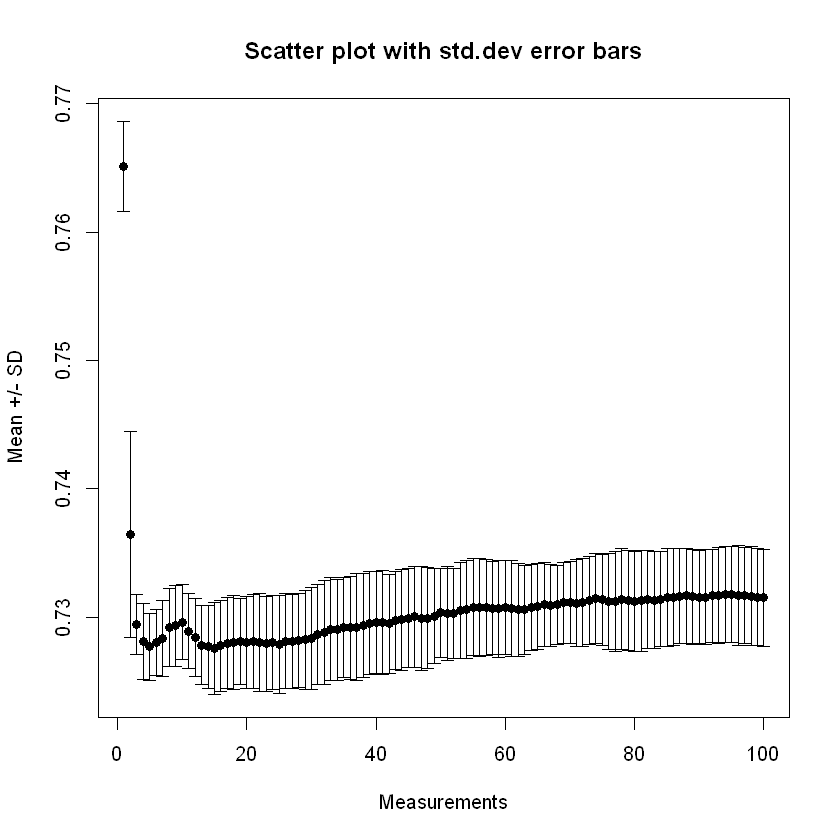

In [318]:
to.plot <- c()
cv.c <- c()
for (i in seq_len(5)){
m1 <- read.csv(file=paste("out/embed/m",toString(i),".csv", sep = ""), sep = ",",header = F) # drops the rownames

test1 <- read.csv(file=paste("out/embed/test",toString(i),".csv", sep = ""), sep = ",",header = F) # drops the rownames
test1 <- unlist(test1)
i.test.c <- rep(FALSE,943*1682)
for (j in seq_len(length(test1))){
    i.test.c[943*(u.data[test1[j]+1,2]-1)+u.data[test1[j]+1,1]]<-TRUE
}
    m1[m1==0]<-NA
    m1[is.na(m1)]<-rep(rowMeans(m1,na.rm=T),1682)[is.na(m1)]
    m1[is.na(m1)]<-rep(colMeans(m1,na.rm=T),943)[is.na(m1)]
m.train <- m1
cv.c <- c(cv.c ,mae(as.matrix(m1)[i.test.c],m.na[i.test.c]))
m.svd <- svd(m.train)
to.plot<-rbind(to.plot,unlist(lapply(seq(100), new.m.cv)))

}
to.plot<-apply(to.plot,2,unlist)
sdev <- apply(to.plot,2,sd) 
sdev
avg <- colMeans(to.plot)
x <- 1:length(avg)
plot(x,colMeans(to.plot),ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Measurements", ylab="Mean +/- SD",
    main="Scatter plot with std.dev error bars"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [317]:
mean(cv.c)

[1] 0.7297082

In [319]:
avg

[1] 0.7651353 0.7364394 0.7294273 0.7281125 0.7276928 0.7280235 0.7283539
  [8] 0.7291918 0.7293407 0.7296165 0.7288894 0.7284068 0.7278224 0.7276889
 [15] 0.7275566 0.7277714 0.7279656 0.7280063 0.7280745 0.7280406 0.7281242
 [22] 0.7280207 0.7279064 0.7280385 0.7278676 0.7281303 0.7281116 0.7281846
 [29] 0.7282391 0.7283349 0.7286504 0.7288090 0.7290700 0.7290156 0.7291980
 [36] 0.7291697 0.7292228 0.7293484 0.7295378 0.7295654 0.7295768 0.7294951
 [43] 0.7297469 0.7297864 0.7299070 0.7300179 0.7298953 0.7299304 0.7300749
 [50] 0.7303263 0.7302734 0.7302815 0.7305183 0.7306049 0.7307556 0.7307271
 [57] 0.7307341 0.7307010 0.7306346 0.7307622 0.7306527 0.7305610 0.7305621
 [64] 0.7307677 0.7308272 0.7309483 0.7308912 0.7309611 0.7311015 0.7311254
 [71] 0.7310963 0.7311514 0.7313135 0.7314384 0.7313362 0.7312342 0.7312371
 [78] 0.7313847 0.7313118 0.7312126 0.7312661 0.7313427 0.7313316 0.7313857
 [85] 0.7315120 0.7315579 0.7316347 0.7316675 0.7315801 0.7315638 0.7315515
 [92] 0.7316501 0.7316987 0.7317840 0.7317350 0.7316794 0.7316881 0.7316100
 [99] 0.7315663 0.7315003